In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Input, Softmax
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


2024-09-05 21:38:29.437130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 21:38:29.449489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 21:38:29.453221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 21:38:29.463061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 21:38:30.159174: W tensorflow/compiler/tf2

In [2]:
print ("Num GPUs Available: ", len(tf.config.list_physical_devices ('GPU')))

Num GPUs Available:  1


I0000 00:00:1725586710.781139   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725586710.816547   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725586710.816769   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# Importar SimpleModel desde el archivo simple.py
# from machine_learning.convnet.simple import SimpleModel

class SimpleModel(tf.keras.Model):
    def __init__(self, number_of_classes):
        super(SimpleModel, self).__init__()        
        self.conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding = 'same',  kernel_initializer = 'he_normal', name = 'conv1')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3), strides = 2, padding = 'same')
        self.relu = tf.keras.layers.ReLU();        
        self.bn_conv_1 = tf.keras.layers.BatchNormalization()
        #self.bn_conv_1 = tf.keras.layers.LayerNormalization()        
        self.conv_2 = tf.keras.layers.Conv2D(64, (3,3), padding = 'same',  kernel_initializer='he_normal', name = 'conv2')
        self.bn_conv_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv_2 = tf.keras.layers.LayerNormalization()
        self.conv_3 = tf.keras.layers.Conv2D(128, (3,3), padding = 'same', kernel_initializer='he_normal', name = 'conv3')
        self.bn_conv_3 = tf.keras.layers.BatchNormalization()     
        #self.bn_conv_3 = tf.keras.layers.LayerNormalization()
        self.fc1 = tf.keras.layers.Dense(256, kernel_initializer='he_normal', name = 'dense1')
        #self.bn_fc_1 = tf.keras.layers.LayerNormalization()
        self.bn_fc_1 = tf.keras.layers.BatchNormalization(name = 'embedding' )
        self.fc2 = tf.keras.layers.Dense(number_of_classes)

    # here, connecting the modules
    def call(self, inputs):        
        #first block
        x = self.conv_1(inputs)    
        x = self.bn_conv_1(x) 
        x = self.relu(x) 
        x = self.max_pool(x)    #14 X 14
        #second block
        x = self.conv_2(x)  
        x = self.bn_conv_2(x) 
        x = self.relu(x) 
        x = self.max_pool(x)  #7X7
        #third block
        x = self.conv_3(x)  
        x = self.bn_conv_3(x)
        x = self.relu(x)  
        x = self.max_pool(x)  #4X4
        #last block        
        x = tf.keras.layers.Flatten()(x) 
        x = self.fc1(x)  
        x = self.bn_fc_1(x) 
        x = self.relu(x) 
        x = self.fc2(x) 
        x = tf.keras.activations.softmax(x)
        return x
    
    def model(self, input_shape):
        x = tf.keras.layers.Input(shape = input_shape)
        return tf.keras.Model(inputs = [x], outputs = self.call(x))

In [4]:
# Correct paths to training and validation datasets
train_dir = 'catdog-large/training_set'
val_dir = 'catdog-large/valid_set'

# Create ImageDataGenerators for loading and augmenting images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=128,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=128,
    class_mode='binary'
)


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


CNN

In [5]:
# Define the CNN model using the provided SimpleModel class
cnn_model = SimpleModel(number_of_classes=2)
cnn_model = cnn_model.model((64, 64, 3))


I0000 00:00:1725586711.007452   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725586711.007787   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725586711.008022   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725586711.080885   61898 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [15]:
# Definir el modelo
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

# Callback para ajustar el learning rate adaptativamente
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitorear la pérdida de validación
    factor=0.5,          # Factor de reducción del learning rate
    patience=7,          # Número de épocas con mejora insuficiente antes de reducir
    min_lr=1e-4          # Learning rate mínimo para evitar caer en cero
)



In [16]:
# Train the CNN model
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Número de épocas ajustable según tus necesidades
    callbacks=[lr_scheduler]
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9901 - loss: 0.0303 - val_accuracy: 0.6990 - val_loss: 2.2641 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9873 - loss: 0.0343 - val_accuracy: 0.7845 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9977 - loss: 0.0118 - val_accuracy: 0.8107 - val_loss: 0.8018 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9943 - loss: 0.0154 - val_accuracy: 0.7973 - val_loss: 1.2414 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9831 - loss: 0.0451 - val_accuracy: 0.6886 - val_loss: 2.0579 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9852 - loss: 0.0416 - val_accuracy: 0.7795 - val_loss: 1.0080 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9922 - loss: 0.0246 - val_a

MLP

In [8]:
# Define the MLP model using the provided MLP class
class MLP(tf.keras.Model):
    # defining components
    def __init__(self, layer_size, n_classes):
        super(MLP, self).__init__()
        self.layer_list = []
        self.flatten = tf.keras.layers.Flatten()  # Added to flatten image inputs
        for lsize in layer_size:
            self.layer_list.append(tf.keras.layers.Dense(lsize))
        self.classifier = tf.keras.layers.Dense(n_classes)

    # defining architecture
    def call(self, inputs):
        x = self.flatten(inputs)  # Flatten the input images
        for mlp_layer in self.layer_list:
            x = mlp_layer(x)
            x = tf.keras.activations.sigmoid(x)
        x = self.classifier(x)
        x = tf.keras.activations.softmax(x)
        return x

# Instantiate the MLP model
mlp_model = MLP([128, 64], 2)  # Using two hidden layers of sizes 128 and 64


In [9]:
# Compile the MLP model
mlp_model.compile(
    optimizer=SGD(),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
# Train the MLP model
mlp_history = mlp_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15  # You can increase the number of epochs based on your requirement
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.5008 - loss: 0.6963 - val_accuracy: 0.5126 - val_loss: 0.6920
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5229 - loss: 0.6922 - val_accuracy: 0.5457 - val_loss: 0.6899
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5363 - loss: 0.6898 - val_accuracy: 0.5571 - val_loss: 0.6884
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5456 - loss: 0.6882 - val_accuracy: 0.5650 - val_loss: 0.6866
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5689 - loss: 0.6859 - val_accuracy: 0.5714 - val_loss: 0.6853
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5675 - loss: 0.6855 - val_accuracy: 0.5719 - val_loss: 0.6848
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5774 - loss: 0.6834 - val_accuracy: 0.5779 - val_loss: 0.6831
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.5813 - loss: 0.6820 - val_accuracy: 0.5764 -

Plots

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5648 - loss: 0.6839
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8113 - loss: 0.8828


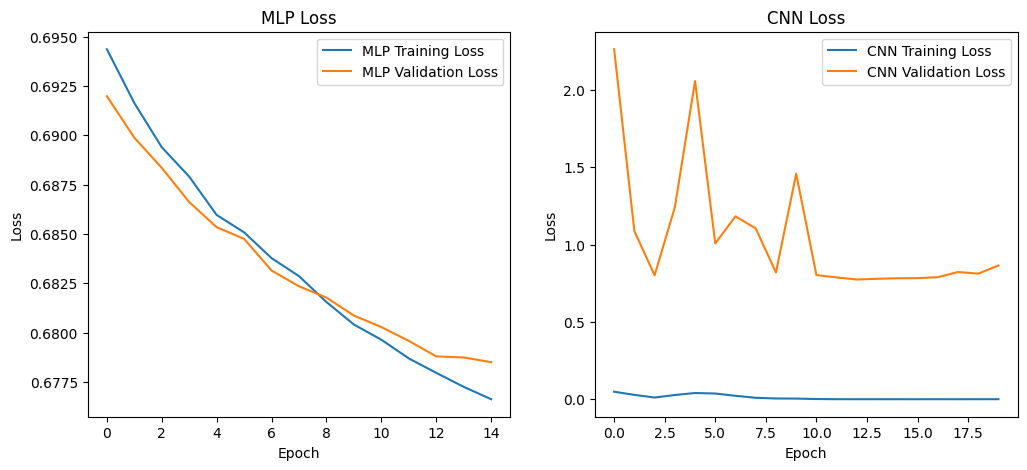

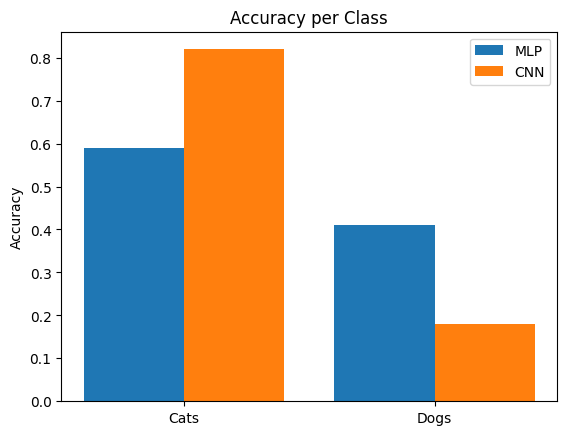

In [17]:
# Evaluar los modelos
mlp_val_loss, mlp_val_acc = mlp_model.evaluate(val_generator)
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(val_generator)

# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(12, 5))

# Pérdida del MLP
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='MLP Training Loss')
plt.plot(mlp_history.history['val_loss'], label='MLP Validation Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Pérdida de la CNN
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Graficar la precisión por clase
class_labels = ['Cats', 'Dogs']
mlp_acc = [mlp_val_acc, 1 - mlp_val_acc]  # Ajusta con la precisión por clase real si disponible
cnn_acc = [cnn_val_acc, 1 - cnn_val_acc]  # Ajusta con la precisión por clase real si disponible

x = np.arange(len(class_labels))

plt.bar(x - 0.2, mlp_acc, 0.4, label='MLP')
plt.bar(x + 0.2, cnn_acc, 0.4, label='CNN')

plt.xticks(x, class_labels)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.legend()
plt.show()
